In [1]:
import json
import os
import pickle
import sys
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import rsatoolbox

with open('../dirs.json', 'r') as f:
    dirs = json.load(f)
sys.path.append(dirs['root'])

from utils.ipm import NeuronLoader
from utils.metrics import DescriminationConfidenceEstimator as DCE
from utils.utils import mkeqdata
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.ndimage import gaussian_filter1d as smooth

nmb_rep = 100

outPath = os.path.join(dirs['out']['rsa'])
os.makedirs(outPath, exist_ok=True)

In [2]:
with open('ground-truth.pickle', 'rb') as f:
    groundTruth = pickle.load(f)

In [3]:
def hist_equalize(matrix):
    matrix = np.copy(matrix)
    shape = matrix.shape
    matrix = matrix.reshape(-1)
    index = matrix.argsort()
    values = np.linspace(0, 1, index.shape[0])
    matrix[index] = values
    return matrix.reshape(shape)

def mkrdm(data):
    rdmat = 1 - cosine_similarity(data)
    return rdmat

def mkherdm(data):
    rdmat = 1 - cosine_similarity(data)
    return hist_equalize(rdmat)

In [4]:
def pltrdm(rdmat, labels, time, outName):
    x = np.arange(len(labels));
    d = (x[1] - x[0]) / 2
    extent = [x[0]-d, x[-1]+d, x[-1]+d, x[0]-d]
    plt.figure(figsize=(30, 30), dpi=50)
    plt.imshow(rdmat, extent=extent)
    plt.title(f'time: {time}', fontsize=50)
    plt.gca().set_xticks(range(len(labels)))
    plt.gca().set_yticks(range(len(labels)))
    plt.gca().set_xticklabels(labels)
    plt.gca().set_yticklabels(labels)
    plt.savefig(outName)
    plt.close()

In [5]:
def movavg(inp, bl, ss):
    nbin = int(np.floor((inp.shape[2] - bl) / ss))
    out = np.nan * np.zeros((inp.shape[0], inp.shape[1], nbin))
    for ibin in range(nbin):
        out[:, :, ibin] = np.sum(inp[:, :, int(ibin*ss):int(ibin*ss)+bl], 2) / bl * 1000
    return out

# Both Monkeys

In [70]:
monkey = "both"
selectivity = "fast"

# grangerInfluence = {}
grangerInfluence = {'itc2pfc': {}, 'pfc2itc': {}}
with open("../utils/info.pkl", "rb") as handler:
    info = pickle.load(handler)
info = info[:165]
sIndex = ((info.sfr == "A") | (info.sfr == "BI"))
noneIndex = (info.cat == "none")

itc = np.load(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}/ITCNoAvg.npy")
pfc = np.load(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}/PFCNoAvg.npy")
itc = itc[~noneIndex & sIndex]
pfc = pfc[~noneIndex & sIndex]
info = info[~noneIndex & sIndex]

info.con = info.con.astype('category')
info.con = info.con.cat.reorder_categories(['human body', 'human face', 'monkey body', 'monkey face', 'natural', 'artificial'])
info.cat = info.cat.astype('category')

# argsort = np.argsort(info.con)
argsort = np.argsort(info.cat)
info = info.iloc[argsort].reset_index(drop=True)
itc = itc[argsort]
pfc = pfc[argsort]

In [71]:
datasetItc = rsatoolbox.data.dataset.TemporalDataset(
    measurements=itc, 
    time_descriptors={'time': np.arange(-200, 700)},
    obs_descriptors={'items': info.con.to_numpy(),
                     'index': info.index}
).bin_time(by='time', bins=np.c_[np.arange(-200, 650), np.arange(-200, 650)+50])
datasetPfc = rsatoolbox.data.dataset.TemporalDataset(
    measurements=pfc, 
    time_descriptors={'time': np.arange(-200, 700)},
    obs_descriptors={'items': info.con.to_numpy(),
                     'index': info.index}
).bin_time(by='time', bins=np.c_[np.arange(-200, 650), np.arange(-200, 650)+50])

In [72]:
rdmItc = rsatoolbox.rdm.calc.calc_rdm_movie(
    dataset=datasetItc,
    method='correlation',
    descriptor='index')

rdmPfc = rsatoolbox.rdm.calc.calc_rdm_movie(
    dataset=datasetPfc,
    method='correlation',
    descriptor='index')

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1], dtype=int8)

In [121]:
from rsatoolbox.rdm import get_categorical_rdm

rdms_model_fo = get_categorical_rdm(info.fac)
rdms_model_bo = get_categorical_rdm(info.bod)
rdms_model_no = get_categorical_rdm(info.nat)
rdms_model_ao = get_categorical_rdm(info.art)
rdms_model_ai = get_categorical_rdm(info.sup.astype('category').cat.codes)
rdms_model_ca = get_categorical_rdm(info.cat.cat.codes.to_numpy())

# model_names = ['independent', 'left/right', 'audio/visual']

# append in one RDMs object

model_rdms = rdms_model_ca
model_rdms.append(rdms_model_ai)
model_rdms.append(rdms_model_fo)
model_rdms.append(rdms_model_bo)
model_rdms.append(rdms_model_ao)
model_rdms.append(rdms_model_no)

# model_names = ['face', 'body', 'artificial', 'natural', 'categories']
model_names = ['categories', 'animate-inanimate', 'face-other', 'body-other', 'artificial-other', 'natural-other']
cond_names  = info.cat.to_numpy()

model_rdms.rdm_descriptors['model_names'] = model_names
model_rdms.pattern_descriptors['cond_names'] = cond_names

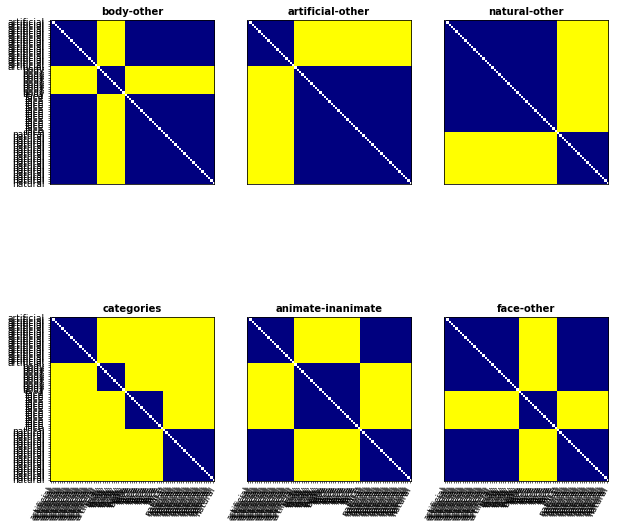

In [122]:
# rsatoolbox.vis.show_rdm(model_rdms, rdm_descriptor='model_names')
rsatoolbox.vis.show_rdm(
    model_rdms, 
    rdm_descriptor='model_names', 
    pattern_descriptor = 'cond_names',
    figsize=(10, 10)
)
None

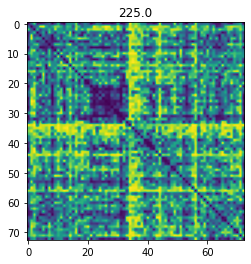

In [85]:
itime = 400
plt.imshow(hist_equalize(rdmItc.get_matrices()[itime]))
plt.title(rdmItc.rdm_descriptors['time'][itime])
None

In [123]:
from scipy.ndimage import gaussian_filter1d as smooth

corrItc = rsatoolbox.rdm.compare_rho_a(rdmItc, model_rdms)
corrPfc = rsatoolbox.rdm.compare_rho_a(rdmPfc, model_rdms)

In [97]:
tim = np.arange(-200, 650) + 25

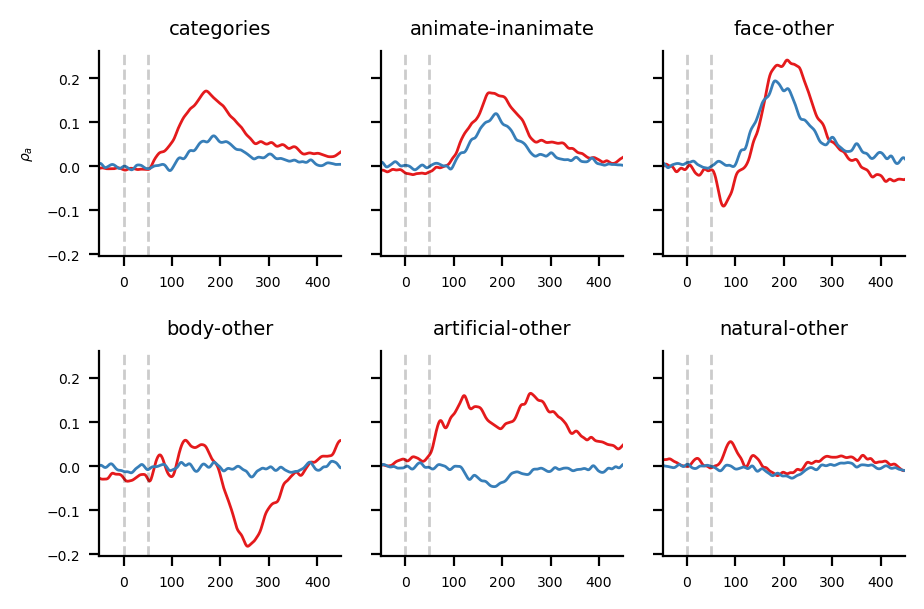

In [133]:
sns.set_palette('Set1')

cm = 1 / 2.54
fig, axs = plt.subplots(2, 3, figsize=(12*cm, 8*cm), sharey=True, dpi=200)

for ax, r_itc, r_pfc, title in zip(axs.flat, corrItc.T, corrPfc.T, model_names):
    ax.plot(tim, smooth(r_itc, 5), lw=1)
    ax.plot(tim, smooth(r_pfc, 5), lw=1)

    ax.axvline(0, color='k', ls='dashed', lw=1, alpha=.2, label='_nolegend_')
    ax.axvline(50, color='k', ls='dashed', lw=1, alpha=.2, label='_nolegend_')
    ax.set_xlim(-50, 450)
    ax.tick_params(axis='both', which='major', labelsize=5)
    ax.set_title(title, fontsize=7)

axs.flat[0].set_ylabel(r'$\rho_a$', fontsize=5)
sns.despine()
fig.tight_layout()

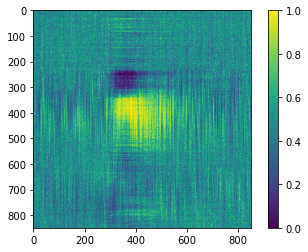

In [25]:
plt.imshow(rdmItc[''] hist_equalize(corr))
plt.colorbar()

In [81]:
rsatoolbox.vis.show_rdm(rdmItc, rdm_descriptor='index', pattern_descriptor = 'cond_names')

KeyboardInterrupt: 

In [9]:
bl, ss = 50, 1

itcb = movavg(itc, bl, ss)
pfcb = movavg(pfc, bl, ss)
timb = np.arange(-200+bl/2, 700-bl/2, ss)

# argsort = np.argsort(info.cat)
rdmItc = np.nan * np.ones([argsort.size, argsort.size, timb.size])
rdmPfc = np.nan * np.ones([argsort.size, argsort.size, timb.size])

for itime in range(timb.size):
    rdmItc[:,:,itime] = mkrdm(itcb[argsort, :, itime])
    rdmPfc[:,:,itime] = mkrdm(pfcb[argsort, :, itime])

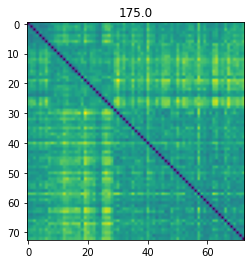

In [10]:
itime = 350
plt.imshow(rdmPfc[:, :, itime])
plt.title(timb[itime]);

In [15]:
rs = {}
for cat in groundTruth.keys():
    for rdm, region_name in zip([rdmItc, rdmPfc], ['itc', 'pfc']):
        tau = []
        gt = groundTruth[cat]
        for itime in range(rdm.shape[2]):
            t = rsatoolbox.rdm.compare_rho_a(rdm[:,:,itime], gt)
            tau.append(t)
        rs[f'{region_name}-{cat}'] = tau

In [18]:
itime = 350
plt.imshow(rs['itc-face'][:, :, itime])
plt.title(timb[itime]);

TypeError: list indices must be integers or slices, not tuple

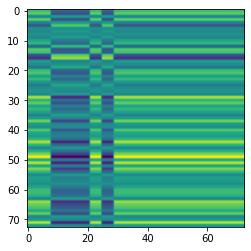

In [26]:
plt.imshow(rs['itc-face'][0])

ValueError: x and y can be no greater than 2D, but have shapes (850,) and (850, 73, 73)

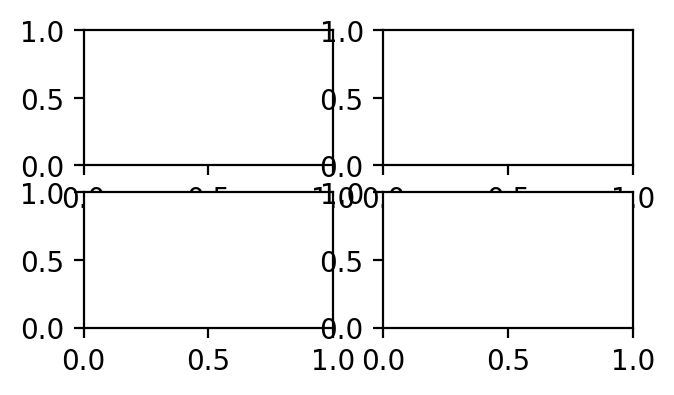

In [17]:
tim = np.arange(-200, 650) + 25

cm = 1 / 2.54
fig, axs = plt.subplots(2, 2, figsize=(9*cm, 5*cm), dpi=200)
for ax, cat in zip(axs.flat, groundTruth.keys()):
    for region in ['itc', 'pfc']:
        tau = np.array(rs[f'{region}-{cat}'])
        tau -= tau[(tim >= -50) & (tim < 0)].mean()
        ax.plot(timb, tau, lw=2, label=region.upper())
    ax.set_title(cat, fontsize=7)

sns.despine()
for ax in axs.flat:
    ax.set_xlim(-50, 450)
    ax.axvline(0, color='k', ls='dashed', lw=1, alpha=.2, label='_nolegend_')
    ax.axvline(50, color='k', ls='dashed', lw=1, alpha=.2, label='_nolegend_')
    ax.tick_params(axis='both', which='major', labelsize=6)

axs[0, 0].legend(frameon=False, fontsize=5)

    # ax.set_title('Granger influence', fontsize=7)
    # ax.legend(frameon=False, fontsize=6)
# plt.legend(["Face-Body", "PrimateFace-PrimateBody", "Animate-Inanimate"], fontsize=5, frameon=False)
# plt.title(f'Similarity to Ground Truth in {region.upper()}', fontsize=titlefontsize)
# plt.xlabel('time (ms)', fontsize=fontsize)
# plt.ylabel('Kendall\'s tau', fontsize=fontsize)
# plt.tick_params(axis='both', which='major', labelsize=fontsize)
# plt.setp(plt.gca().spines.values(), linewidth=2)

fig.tight_layout()

# plt.savefig(os.path.join(out_path, f'rsa-{region.lower()}'), dpi=600)

In [ ]:
region = "pfc"
X = data.it if region=='it' else data.pfc
y = grablabels(hierarchy='categories')

img_index = np.arange(1, y.size+1)[np.argwhere(~np.isnan(y)).squeeze()]
X = X[np.argwhere(~np.isnan(y)).squeeze()]
y = y[np.argwhere(~np.isnan(y)).squeeze()]

yc = np.full(y.size, 'xx')
yc[y==0] = 'af'
yc[y==1] = 'hf'
yc[y==2] = 'mf'
yc[y==3] = 'hb'
yc[y==4] = 'mb'
yc[y==5] = 'ab'
yc[y==6] = 'xn'
yc[y==7] = 'xa'

argsort = np.argsort(y)
rdmat = np.nan * np.ones([argsort.size, argsort.size, X.shape[2]])
herdmat = np.nan * np.ones([argsort.size, argsort.size, X.shape[2]])

for itime in range(X.shape[2]):
    rdmat[:,:,itime] = mkrdm(X[argsort, :, itime])
    herdmat[:,:,itime] = mkherdm(X[argsort, :, itime])

In [ ]:
lbl = np.array([yc[argsort][x] + '-' + str(img_index[argsort][x]) for x in range(len(argsort))])

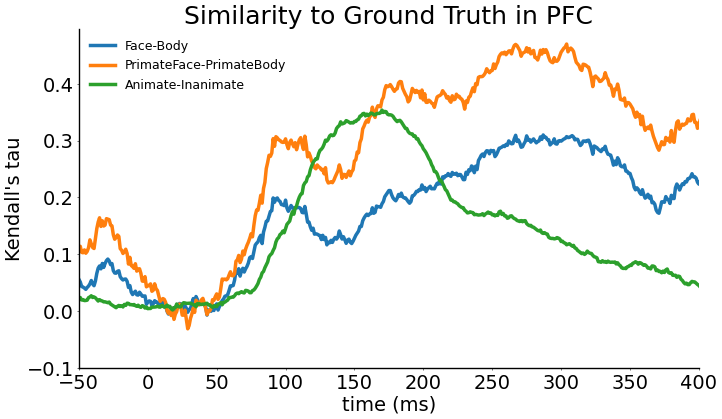

In [ ]:
fontsize = 28
titlefontsize = 36

plt.figure(figsize=(16, 9), dpi=50)
for o in ['f-b', 'pf-pb', 'a-i']:
    tau = []
    ind = np.argwhere(~np.isnan(np.diag(gtruth[o]))).squeeze()
    gt = gtruth[o][ind][:, ind]
    rdm = rdmat[ind][:, ind]
    for itime in range(rdmat.shape[2]):
        t, _ = kendalltau(rdm[:,:,itime], gt)
        tau.append(t)
    plt.plot(data.time, tau, lw=5)

sns.despine()
plt.xlim(-50, 400)
plt.legend(["Face-Body", "PrimateFace-PrimateBody", "Animate-Inanimate"], fontsize=18, frameon=False)
plt.title(f'Similarity to Ground Truth in {region.upper()}', fontsize=titlefontsize)
plt.xlabel('time (ms)', fontsize=fontsize)
plt.ylabel('Kendall\'s tau', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.setp(plt.gca().spines.values(), linewidth=2)

plt.savefig(os.path.join(out_path, f'rsa-{region.lower()}'), dpi=600)

# Single Monkey

In [4]:
selectivity = "fast"
monkey = "jenab"
data = NeuronReader(f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}')

In [10]:
out_path = f"G:/Codes/Processing/out/rsa/{monkey.capitalize()}-{selectivity.capitalize()}"

In [15]:
region = "pfc"
X = data.it if region=='it' else data.pfc
y = grablabels(hierarchy='categories')

img_index = np.arange(1, y.size+1)[np.argwhere(~np.isnan(y)).squeeze()]
X = X[np.argwhere(~np.isnan(y)).squeeze()]
y = y[np.argwhere(~np.isnan(y)).squeeze()]

yc = np.full(y.size, 'xx')
yc[y==0] = 'af'
yc[y==1] = 'hf'
yc[y==2] = 'mf'
yc[y==3] = 'hb'
yc[y==4] = 'mb'
yc[y==5] = 'ab'
yc[y==6] = 'xn'
yc[y==7] = 'xa'

argsort = np.argsort(y)
rdmat = np.nan * np.ones([argsort.size, argsort.size, X.shape[2]])
herdmat = np.nan * np.ones([argsort.size, argsort.size, X.shape[2]])

for itime in range(X.shape[2]):
    rdmat[:,:,itime] = mkrdm(X[argsort, :, itime])
    herdmat[:,:,itime] = mkherdm(X[argsort, :, itime])

In [16]:
lbl = np.array([yc[argsort][x] + '-' + str(img_index[argsort][x]) for x in range(len(argsort))])

In [17]:
for itime in np.arange(0, data.time.size, 5):
    pltrdm(herdmat[:,:,itime], lbl, data.time[itime], os.path.join(out_path, 'rdm', region.upper(), f'rdm-{int(itime)}.png'))

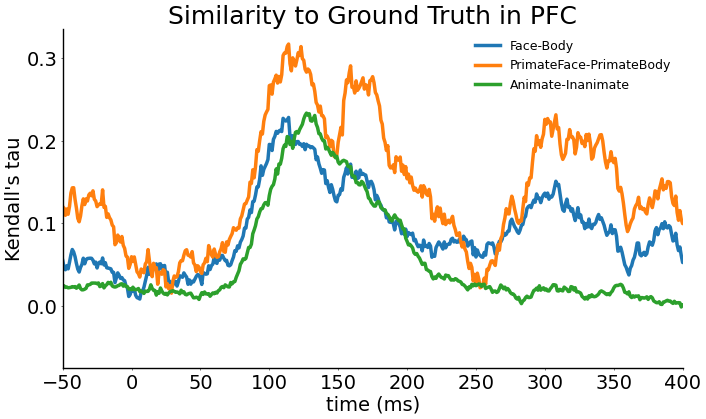

In [19]:
fontsize = 28
titlefontsize = 36

plt.figure(figsize=(16, 9), dpi=50)
for o in ['f-b', 'pf-pb', 'a-i']:
    tau = []
    ind = np.argwhere(~np.isnan(np.diag(gtruth[o]))).squeeze()
    gt = gtruth[o][ind][:, ind]
    rdm = rdmat[ind][:, ind]
    for itime in range(rdmat.shape[2]):
        t, _ = kendalltau(rdm[:,:,itime], gt)
        tau.append(t)
    plt.plot(data.time, tau, lw=5)

sns.despine()
plt.xlim(-50, 400)
plt.legend(["Face-Body", "PrimateFace-PrimateBody", "Animate-Inanimate"], fontsize=18, frameon=False)
plt.title(f'Similarity to Ground Truth in {region.upper()}', fontsize=titlefontsize)
plt.xlabel('time (ms)', fontsize=fontsize)
plt.ylabel('Kendall\'s tau', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.setp(plt.gca().spines.values(), linewidth=2)

plt.savefig(os.path.join(out_path, f'rsa-{region.lower()}'), dpi=600)